<a href="https://colab.research.google.com/github/IfyBillions/Data-Science-Project/blob/main/Utilizing_Machine_Learning_regression_algorithms_to_predict_house_prices_in_Milan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import time
import re
import warnings
warnings.filterwarnings('ignore')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Splitting into training and testing sets
from sklearn.model_selection import train_test_split

# Scaling data
from sklearn.preprocessing import StandardScaler

# models
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor



# evaluation metrics
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import  r2_score, mean_absolute_error, mean_squared_error

In [ ]:
milan_housing=pd.read_csv("milan_housing.csv")
milan_housing.shape

(2130, 34)

In [ ]:
milan_housing.head()

,index,rooms,m2,bathrooms,floor,condominium_expenses,date,contract,typology,total_floors,...,energy_certification,co2_emissions,elevator,floor_level,heating_centralized,heating_radiator,heating_gas,air_conditiong_centralized,air_conditioning_heat,renewable_energy_performance_index_KWh/m2
0,0,3,140.0,2,4,535,08/02/2023,sale,apartment | entire property | stately property...,6 floors,...,NaN,NaN,1,4,centralized,to radiators,methane powered,autonomous,cold/hot,NaN
1,0,4,121.0,2,3,200,17/02/2023,sale,apartment | entire property | stately property...,7 floors,...,NaN,NaN,1,3,autonomous,to radiators,gas powered,system preparation,NaN,NaN
2,0,2,55.0,1,4,133,20/02/2023,sale,attic | entire property | stately property class,4 floors,...,NaN,NaN,1,4,autonomous,to radiators,gas powered,autonomous,cold/hot,NaN
3,0,2,60.0,1,5,333,11/01/2023,sale,attic | bare ownership | medium property class,5 floors,...,NaN,NaN,1,5,centralized,to radiators,methane powered,autonomous,cold,NaN
4,0,4,220.0,3,4,NaN,23/01/2023,sale,apartment | entire property | stately property...,7 floors,...,NaN,NaN,1,4,centralized,to radiators,methane powered,autonomous,cold/hot,351.0


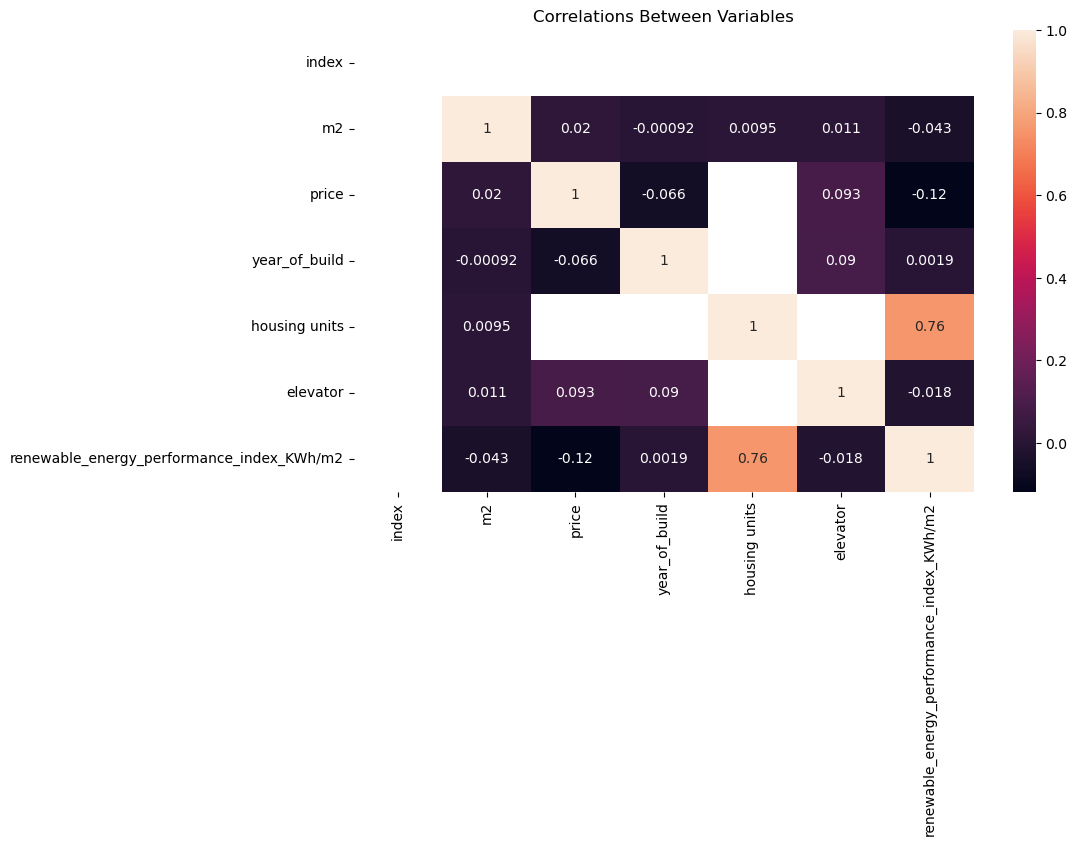

In [ ]:
#checking the correlation of features with the target column
correlation_matrix = milan_housing.corr()
correlation_matrix

plt.figure(figsize=(10,6))
sns.heatmap(correlation_matrix, annot=True)
plt.title("Correlations Between Variables")
plt.show()

### Feature Selection

Selecting numerical features

In [ ]:
cor_with_target = correlation_matrix['price']
cor_with_target

index                                             NaN
m2                                           0.020325
price                                        1.000000
year_of_build                               -0.066123
housing units                                     NaN
elevator                                     0.093485
renewable_energy_performance_index_KWh/m2   -0.119017
Name: price, dtype: float64

In [ ]:
# Dropping index an housing as they have no correlation with "price"
new_milan_housing = milan_housing.drop(["index","housing units"], axis=1)
new_milan_housing

,rooms,m2,bathrooms,floor,condominium_expenses,date,contract,typology,total_floors,availability,...,energy_certification,co2_emissions,elevator,floor_level,heating_centralized,heating_radiator,heating_gas,air_conditiong_centralized,air_conditioning_heat,renewable_energy_performance_index_KWh/m2
0,3,140.0,2,4,535,08/02/2023,sale,apartment | entire property | stately property...,6 floors,libero,...,NaN,NaN,1,4,centralized,to radiators,methane powered,autonomous,cold/hot,NaN
1,4,121.0,2,3,200,17/02/2023,sale,apartment | entire property | stately property...,7 floors,libero,...,NaN,NaN,1,3,autonomous,to radiators,gas powered,system preparation,NaN,NaN
2,2,55.0,1,4,133,20/02/2023,sale,attic | entire property | stately property class,4 floors,libero,...,NaN,NaN,1,4,autonomous,to radiators,gas powered,autonomous,cold/hot,NaN
3,2,60.0,1,5,333,11/01/2023,sale,attic | bare ownership | medium property class,5 floors,libero,...,NaN,NaN,1,5,centralized,to radiators,methane powered,autonomous,cold,NaN
4,4,220.0,3,4,NaN,23/01/2023,sale,apartment | entire property | stately property...,7 floors,libero,...,NaN,NaN,1,4,centralized,to radiators,methane powered,autonomous,cold/hot,351.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2125,2,70.0,1,10,135,26/02/2023,sale,apartment | entire property | stately property...,11 floors,libero,...,NaN,NaN,1,1,centralized,by air,methane powered,autonomous,cold/hot,NaN
2126,3,90.0,2,R,183,19/02/2023,sale,apartment | entire property | medium property ...,7 floors,libero,...,NaN,NaN,1,0,centralized,to radiators,methane powered,autonomous,cold,NaN
2127,3,130.0,2,T,200,26/02/2023,sale,apartment | entire property | stately property...,4 floors,libero,...,NaN,NaN,0,0,autonomous,by air,powered by heat pump,autonomous,cold/hot,NaN
2128,2,51.0,1,1,NaN,26/02/2023,sale,apartment | entire property | stately property...,5 floors,libero,...,NaN,NaN,1,1,autonomous,to radiators,gas powered,system preparation,NaN,NaN


### Checking for missing values

In [ ]:
new_milan_housing.isna().sum()

rooms                                          14
m2                                             17
bathrooms                                      25
floor                                         281
condominium_expenses                          460
date                                           14
contract                                       14
typology                                       14
total_floors                                   47
availability                                  441
other_features                                 36
price                                         143
year_of_build                                 237
condition                                     113
air_conditioning                              519
energy_efficiency                             154
city                                           14
neighborhood                                   14
car_parking                                  1542
energy_performance_building                  1897


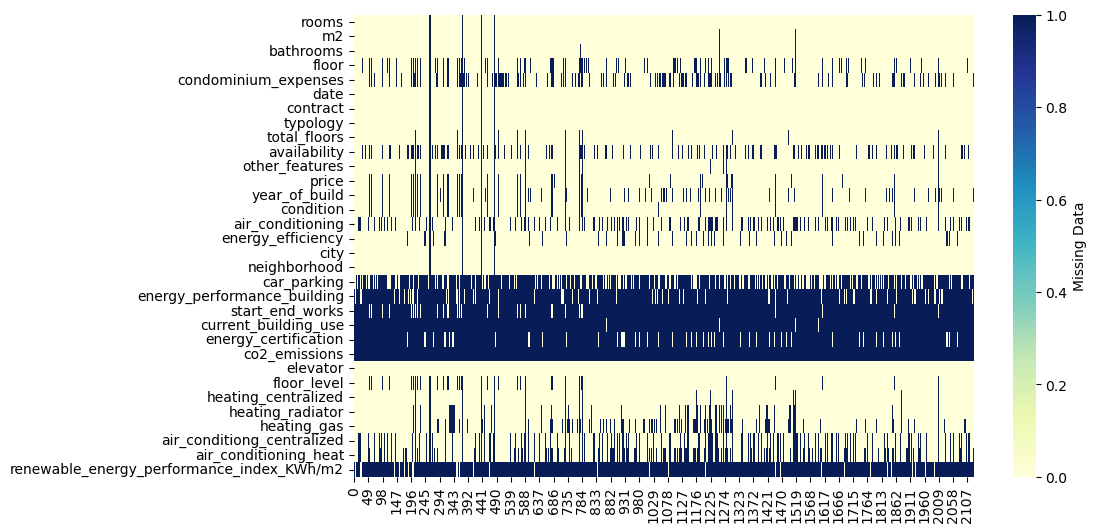

In [ ]:
# Visualising missing data
plt.figure(figsize=(10,6))
sns.heatmap(new_milan_housing.isna().transpose(),vmin=0, vmax=1, cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'});

plt.savefig("missing_data_with_heatmap.png", dpi=100);

In [ ]:
# Selecting relevant columns
relevant_columns = ["rooms", "m2", "bathrooms","floor","condominium_expenses",
                    "availability", "price", "year_of_build",
                    "condition", "air_conditioning", "energy_efficiency",
                    "neighborhood", "car_parking","elevator"]
new_milan_housing = new_milan_housing[relevant_columns]

In [ ]:
new_milan_housing.isna().sum()

rooms                     14
m2                        17
bathrooms                 25
floor                    281
condominium_expenses     460
availability             441
price                    143
year_of_build            237
condition                113
air_conditioning         519
energy_efficiency        154
neighborhood              14
car_parking             1542
elevator                   0
dtype: int64

### Data Cleaning

In [ ]:
# Provide a summary of the dataset
print(f'Data contains {new_milan_housing.shape[0]} records and {new_milan_housing.shape[1]} columns.\n')
print("Data Types:\n")
print(new_milan_housing.dtypes)
print("\nSummary Statistics:\n")
print(new_milan_housing.describe())

Data contains 2130 records and 14 columns.

Data Types:

rooms                    object
m2                      float64
bathrooms                object
floor                    object
condominium_expenses     object
availability             object
price                   float64
year_of_build           float64
condition                object
air_conditioning         object
energy_efficiency        object
neighborhood             object
car_parking              object
elevator                  int64
dtype: object

Summary Statistics:

                 m2         price  year_of_build     elevator
count  2.113000e+03  1.987000e+03    1893.000000  2130.000000
mean   7.096091e+02  7.311284e+05    1961.295827     0.785446
std    2.719078e+04  6.619799e+05      52.262219     0.410609
min    1.000000e+00  2.000000e+04    1100.000000     0.000000
25%    7.000000e+01  3.295000e+05    1940.000000     1.000000
50%    1.000000e+02  5.200000e+05    1960.000000     1.000000
75%    1.400000e+02  8.68

In [ ]:
# Define the mappings for floor types and ordinal categories
floor_types = {
    "S": -1,
    "T": 0,
    "M": 0.5
}

ordinal_categories = [
    'new / under construction',
    'very good / refurbished',
    'good / habitable',
    'to be restructured'
]

category_codes = ['NEW', 'VG', 'G', 'TBR']

ordinal_dtype = pd.CategoricalDtype(categories=ordinal_categories, ordered=True)

In [ ]:
## Categorical
import pandas as pd

def extract_energy_class(energy_efficiency):
    """
    Extract the energy class from the energy efficiency value.
    """
    if pd.notnull(energy_efficiency) and len(energy_efficiency) > 0:
        return energy_efficiency[0].upper()
    return None

# Assuming milan_housing is your pandas DataFrame containing the data
if "energy_efficiency" in new_milan_housing.columns:
    new_milan_housing['energy_class'] = new_milan_housing['energy_efficiency'].apply(extract_energy_class).astype('object')
else:
    print("Error: 'energy_efficiency' column not found in the DataFrame.")

In [ ]:
# Numeric
import pandas as pd
import re

def extract_numeric_values_from_string(value):
    """
    Extracts numeric values from a given string.

    Args:
        value (str): Input string that may contain numeric values.

    Returns:
        float or None: The extracted numeric value as a float, or None if no numeric value is found.
    """
    pattern = r'\d+'  #-- Matches one or more digits
    match = re.search(pattern, value)
    if match:
        return int(match.group())
    else:
        return None

def convert_to_numeric(df, column):
    """
    Converts the values in the specified columns of the DataFrame to numeric types.

    Args:
        df (pandas.DataFrame): The DataFrame.
        columns (list): A list of column names to convert.

    Returns:
        pandas.DataFrame: The DataFrame with converted numeric values.
    """
    return pd.to_numeric(df[column].astype(str).apply(extract_numeric_values_from_string), errors='coerce')

new_milan_housing['rooms'] = convert_to_numeric(milan_housing, "rooms")
new_milan_housing['m2'] = convert_to_numeric(milan_housing, "m2")
new_milan_housing['bathrooms'] = convert_to_numeric(milan_housing, "bathrooms")
new_milan_housing['condominium_expenses'] = convert_to_numeric(milan_housing, "condominium_expenses")
new_milan_housing['floor'] = pd.to_numeric(milan_housing['floor'].map(floor_types).fillna(milan_housing['floor']), errors='coerce')

new_milan_housing['energy_efficiency'] = new_milan_housing['energy_efficiency'].str.extract(r'(\d+[\.,]?\d*)')
new_milan_housing['energy_efficiency'] = new_milan_housing['energy_efficiency'].str.replace(',','.').astype(str)

In [ ]:
# Boolean

# Function to convert a column to boolean type and fill missing values with False
def convert_to_boolean(df, column):
    df[column] = df[column].fillna(False).astype(bool)

# Columns to be converted to boolean type
boolean_columns = ['air_conditioning', 'availability', 'car_parking', 'elevator']

# Apply the function to each column
for column in boolean_columns:
    convert_to_boolean(new_milan_housing, column)

In [ ]:
new_milan_housing.dtypes

rooms                   float64
m2                      float64
bathrooms               float64
floor                   float64
condominium_expenses    float64
availability               bool
price                   float64
year_of_build           float64
condition                object
air_conditioning           bool
energy_efficiency        object
neighborhood             object
car_parking                bool
elevator                   bool
energy_class             object
dtype: object

In [ ]:
new_milan_housing.describe()

,rooms,m2,bathrooms,floor,condominium_expenses,price,year_of_build
count,2116.000000,2.113000e+03,2102.000000,1656.000000,1670.000000,1.987000e+03,1893.000000
mean,3.525520,7.096091e+02,1.972407,2.923913,234.590419,7.311284e+05,1961.295827
std,16.257119,2.719078e+04,2.855258,2.497178,162.023635,6.619799e+05,52.262219
min,0.000000,1.000000e+00,1.000000,-1.000000,1.000000,2.000000e+04,1100.000000
25%,2.000000,7.000000e+01,1.000000,1.000000,125.000000,3.295000e+05,1940.000000
50%,3.000000,1.000000e+02,2.000000,2.000000,200.000000,5.200000e+05,1960.000000
75%,4.000000,1.400000e+02,2.000000,4.000000,300.000000,8.680000e+05,1990.000000
max,740.000000,1.250000e+06,71.000000,19.000000,950.000000,5.300000e+06,2025.000000


In [ ]:
import pandas as pd
import numpy as np

def remove_outliers(df, num_std=3, numeric_data_types=['int', 'float']):
    """
    Removes outliers in numeric columns of the DataFrame based on z-scores.

    Args:
        df (pandas.DataFrame): The DataFrame to analyze.
        num_std (int): The number of standard deviations to use as the outlier threshold.
        numeric_data_types (list): The data types to consider for outlier detection.

    Returns:
        pandas.DataFrame: A new DataFrame with rows that have no outliers.
    """
    numeric_columns = df.select_dtypes(include=numeric_data_types)
    z_scores = np.abs((numeric_columns - numeric_columns.mean()) / numeric_columns.std())
    outlier_mask = z_scores > num_std
    return df[~outlier_mask.any(axis=1)]

# Assuming milan_housing is your pandas DataFrame containing the data

# Set the number of standard deviations as the threshold for outlier detection
threshold = 3

# Detect outliers and obtain a DataFrame with rows that have no outliers
milan_outliers = remove_outliers(new_milan_housing, num_std=threshold)

# Optional: If you want to reset the DataFrame index after filtering, use the following line
# milan_outliers.reset_index(drop=True, inplace=True)

milan_outliers

,rooms,m2,bathrooms,floor,condominium_expenses,availability,price,year_of_build,condition,air_conditioning,energy_efficiency,neighborhood,car_parking,elevator,energy_class
0,3.0,140.0,2.0,4.0,535.0,True,880000.0,1900.0,very good / refurbished,True,248.59,centrale,False,True,D
1,4.0,121.0,2.0,3.0,200.0,True,649000.0,1960.0,very good / refurbished,True,3.51,centrale,False,True,E
2,2.0,55.0,1.0,4.0,133.0,True,300000.0,2006.0,good / habitable,True,183.89,viale ungheria - mecenate,True,True,E
3,2.0,60.0,1.0,5.0,333.0,True,250000.0,1960.0,very good / refurbished,True,138.8,città studi,False,True,F
4,4.0,220.0,3.0,4.0,NaN,True,2250000.0,1970.0,good / habitable,True,3.51,piave - tricolore,True,True,G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2125,2.0,70.0,1.0,10.0,135.0,True,338000.0,2009.0,very good / refurbished,True,3.51,bicocca,False,True,B
2126,3.0,90.0,2.0,NaN,183.0,True,280000.0,1960.0,very good / refurbished,True,174,lorenteggio,False,True,F
2127,3.0,130.0,2.0,0.0,200.0,True,625000.0,1940.0,very good / refurbished,True,175,melchiorre gioia,False,False,F
2128,2.0,51.0,1.0,1.0,NaN,True,440000.0,NaN,very good / refurbished,True,193.44,porta venezia,False,True,F


## Data Visualisation

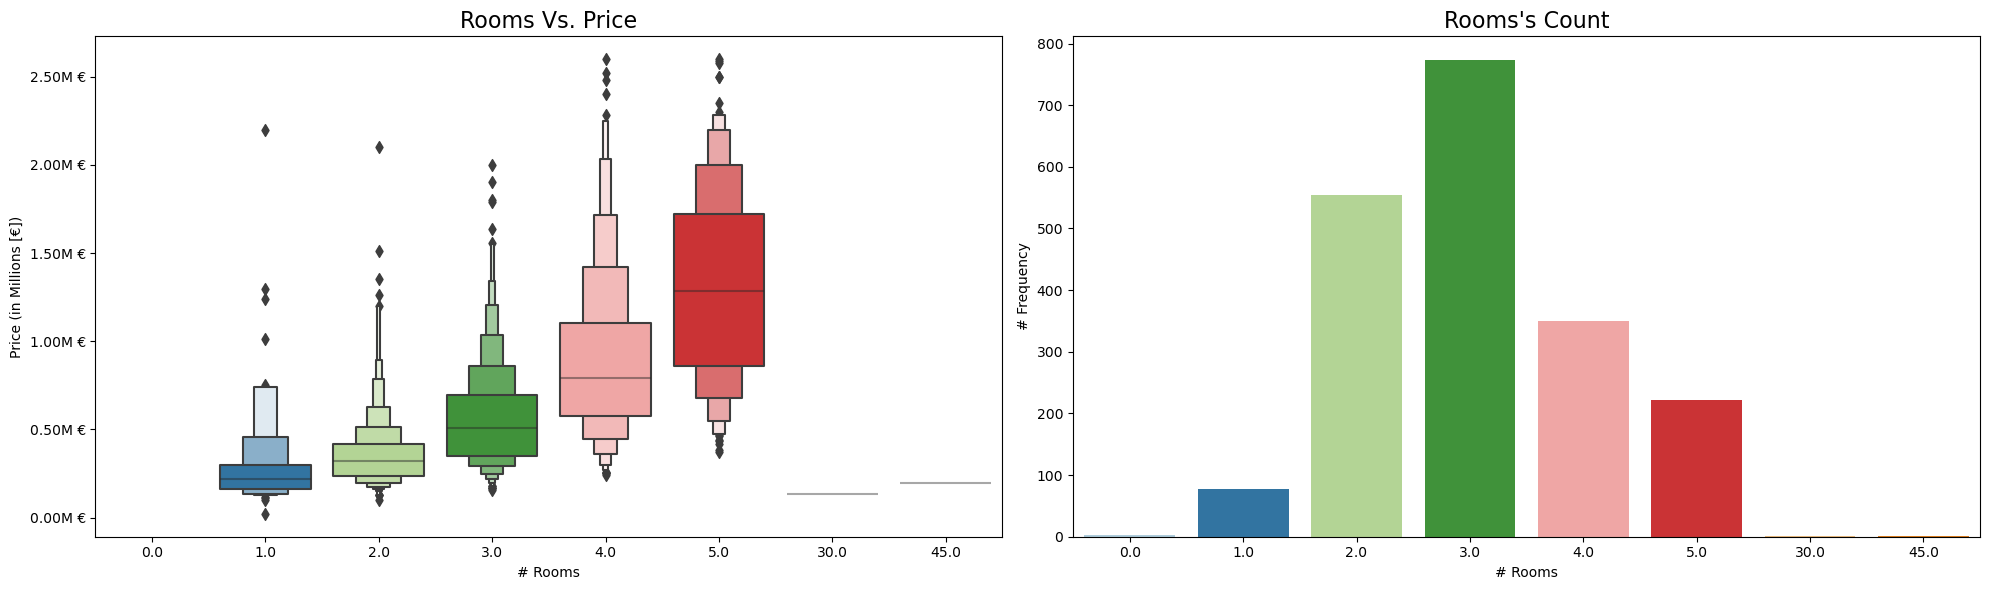

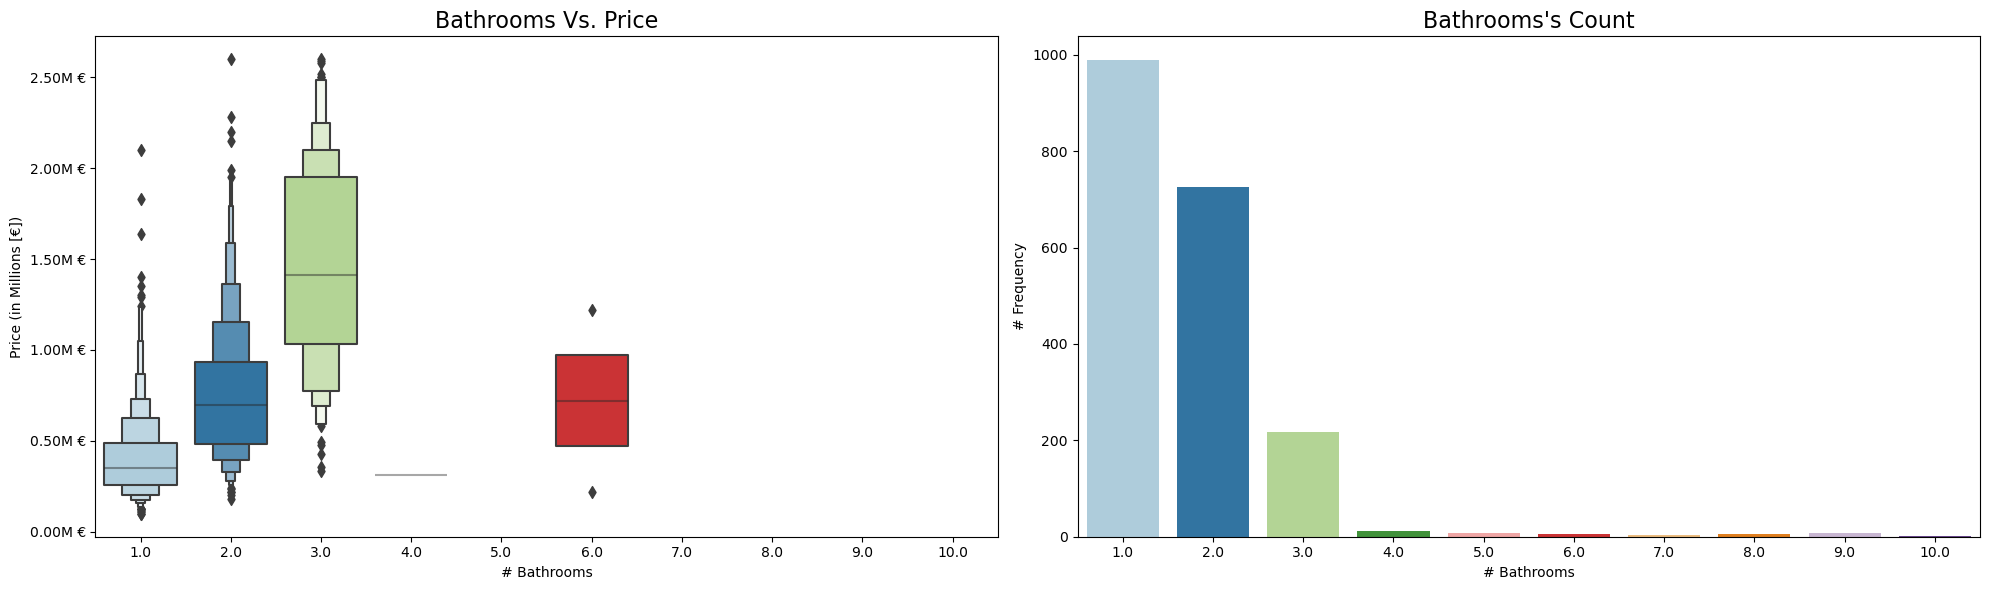

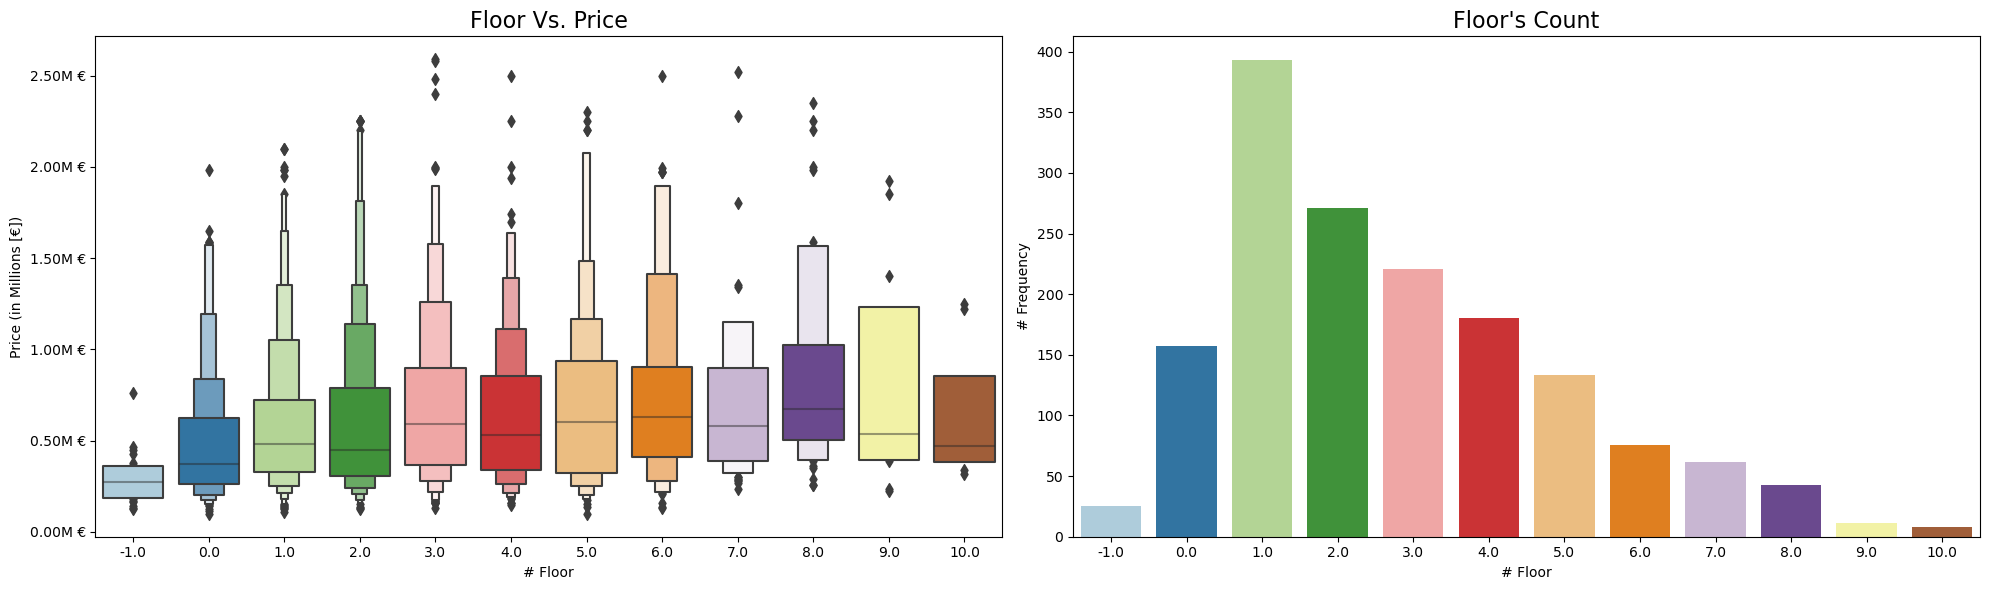

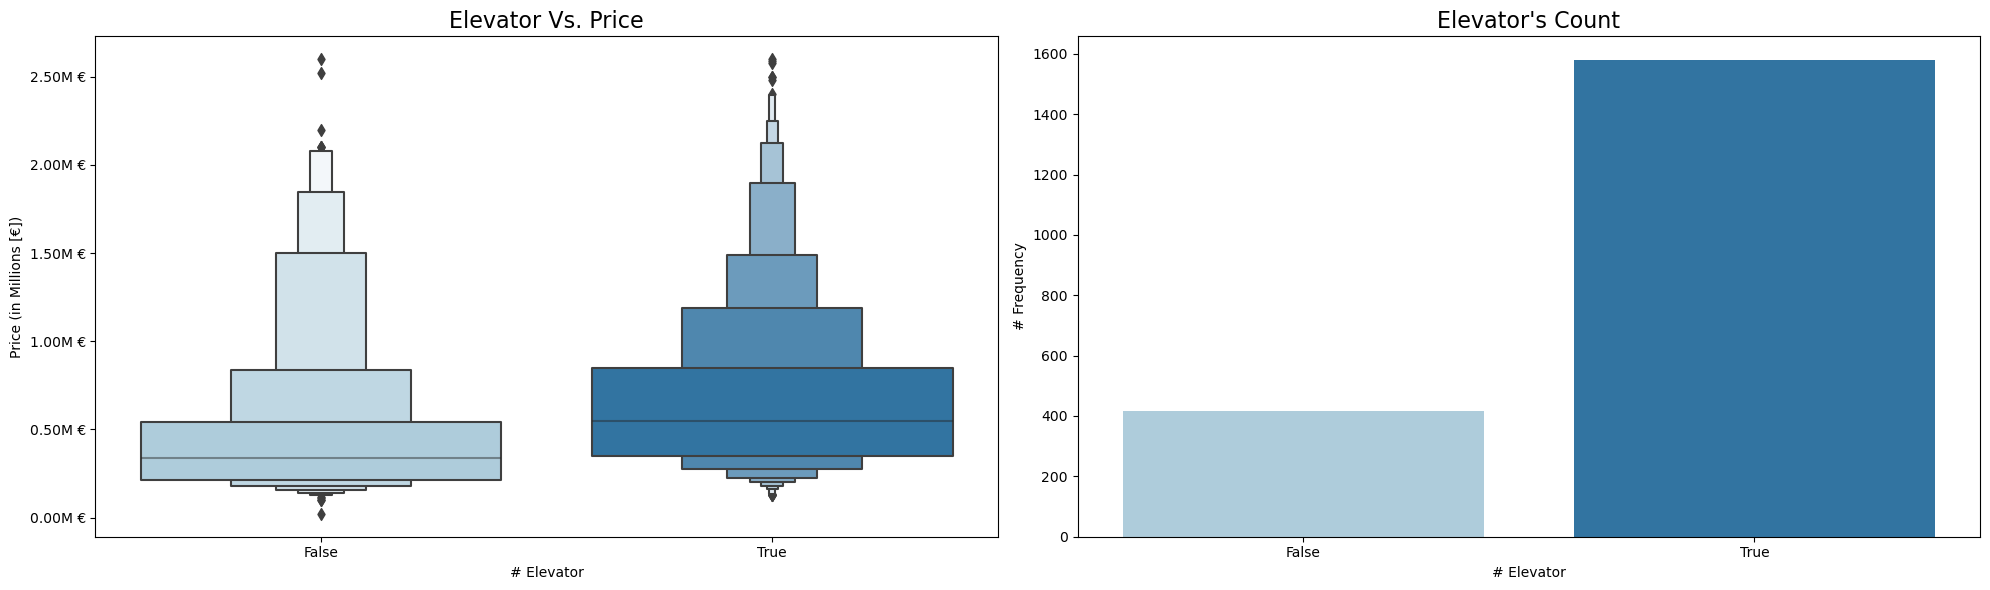

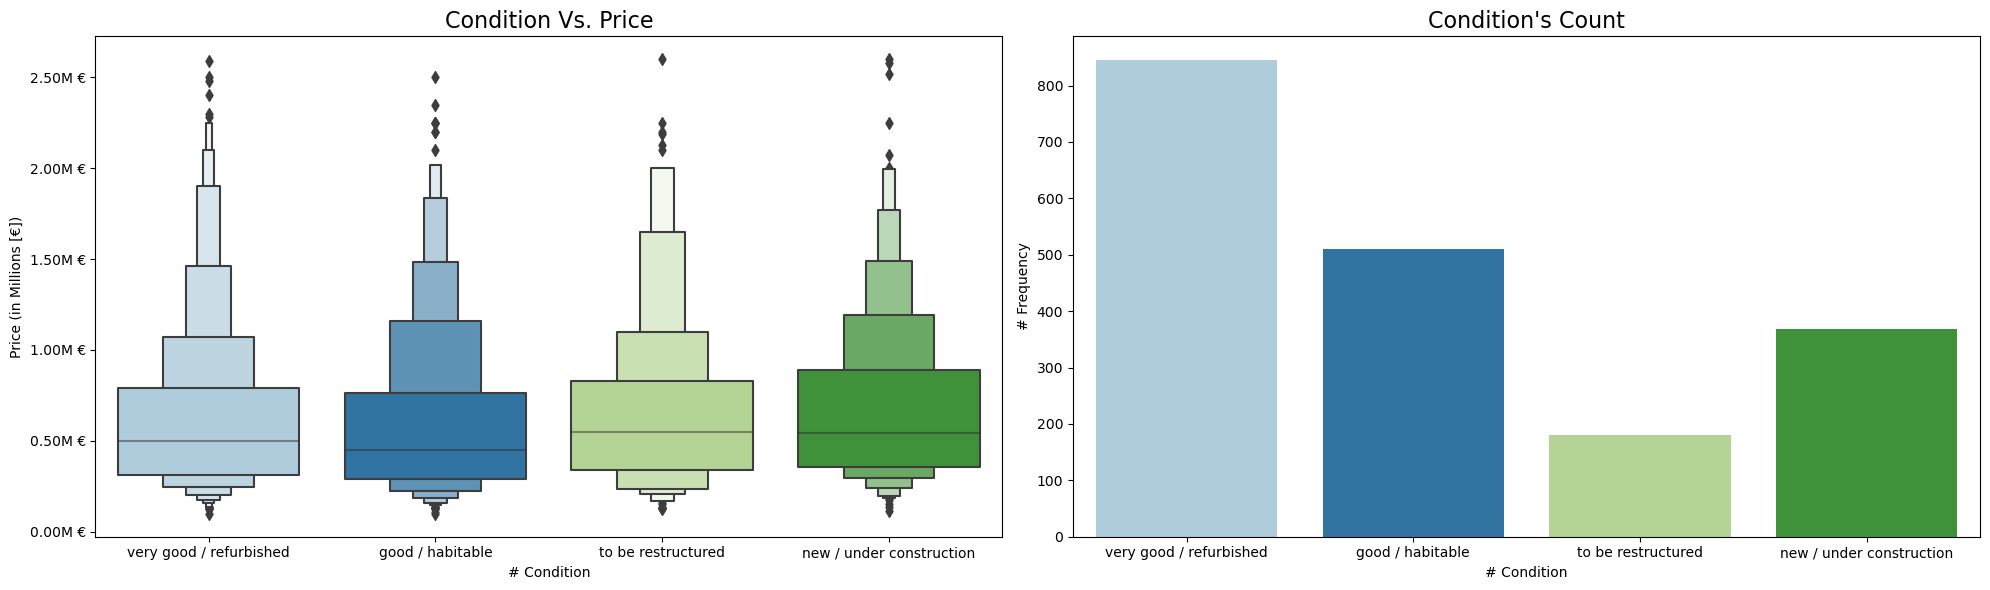

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def draw_subplots(df, feature, target='price'):
    plt.figure(figsize=(20, 6))
    sns.set_palette('Paired')

    # Boxenplot
    plt.subplot(1, 2, 1)
    sns.boxenplot(data=df, x=feature, y=target)
    plt.title(f'{feature.capitalize()} Vs. {target.capitalize()}', fontsize=16)
    plt.xlabel(f'# {feature.capitalize()}')
    plt.ylabel(f"{target.capitalize()} (in Millions [€])")
    plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x/(1000000)) + 'M €'))

    # Countplot
    plt.subplot(1, 2, 2)
    sns.countplot(data=df, x=feature)
    plt.title(f'{feature.capitalize()}\'s Count', fontsize=16)
    plt.xlabel(f'# {feature.capitalize()}')
    plt.ylabel("# Frequency")

    plt.tight_layout()
    plt.show()

# Visualize 'rooms' against 'price'
draw_subplots(milan_outliers, "rooms")

# Visualize 'bathrooms' against 'price'
draw_subplots(milan_outliers, "bathrooms")

# Visualize 'floor' against 'price'
draw_subplots(milan_outliers, "floor")

# Visualize 'condominium_expenses' against 'price'
draw_subplots(milan_outliers, "elevator")

# Visualize 'condition' against 'price'
draw_subplots(milan_outliers, "condition")

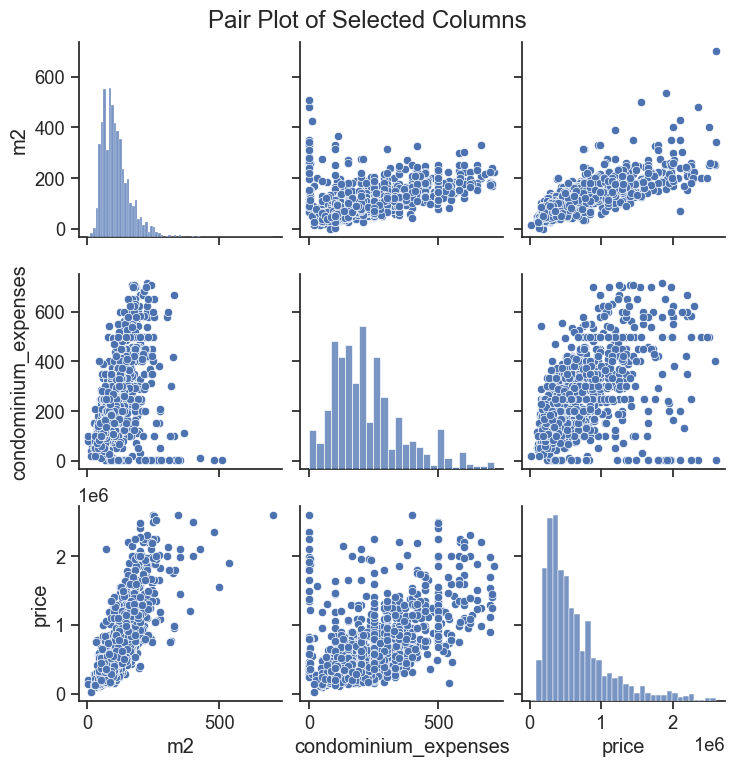

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def create_pairplot(data, columns, diag_kind='hist', plot_title=None):
    """
    Creates a pair plot for the specified columns of the given DataFrame.

    Args:
        data (pandas.DataFrame): The DataFrame containing the data.
        columns (list): List of column names to include in the pair plot.
        diag_kind (str): Type of diagonal plots ('hist' or 'kde').
        plot_title (str): Title for the pair plot.

    Returns:
        None
    """
    sns.set(style="ticks")
    sns.set_context("notebook", font_scale=1.2)

    pair_plot = sns.pairplot(data[columns], diag_kind=diag_kind, height=2.5)

    if plot_title:
        pair_plot.fig.suptitle(plot_title, y=1.02)

    plt.show()

# Assuming milan_outliers is your pandas DataFrame containing the data
selected_columns = ['m2', 'condominium_expenses', 'price', 'energy_efficiency']
plot_title = "Pair Plot of Selected Columns"

create_pairplot(milan_outliers, selected_columns, diag_kind='hist', plot_title=plot_title)


<Figure size 800x500 with 0 Axes>

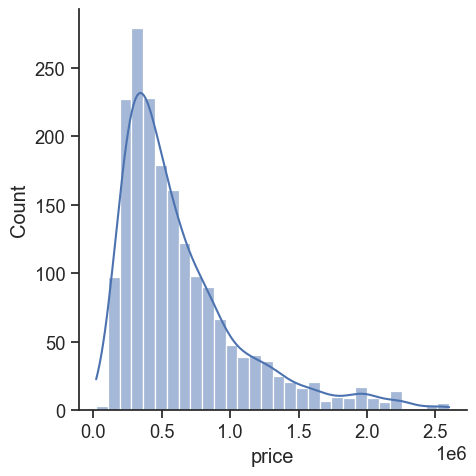

In [ ]:
# Price distribution
plt.figure(figsize=(8,5))
sns.displot(milan_outliers['price'] , bins=30 , kde=True )

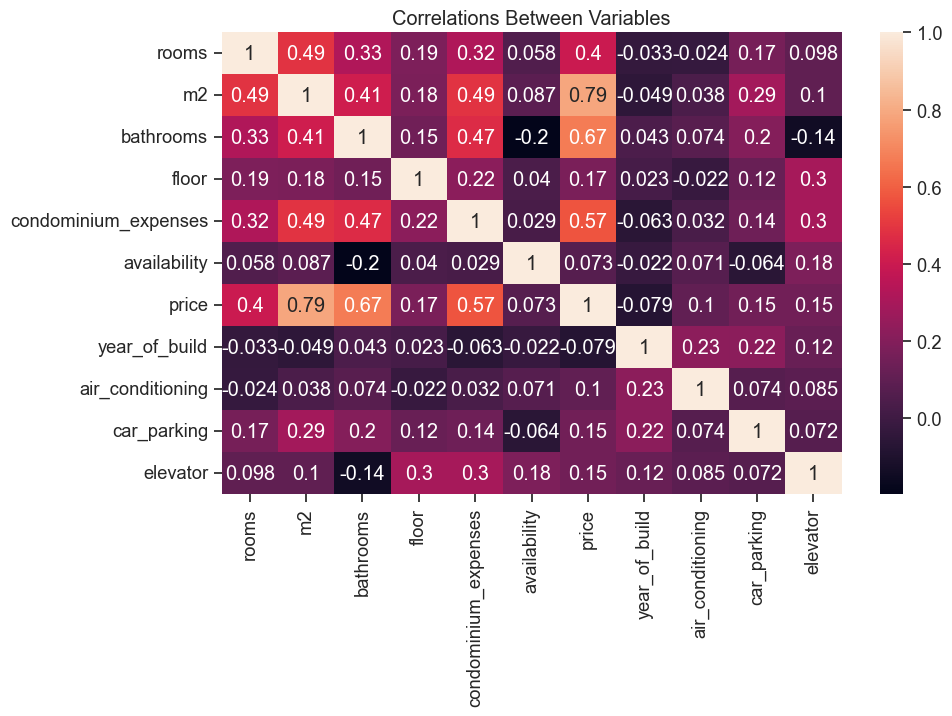

In [ ]:
#checking the correlation of features with the target column
corr = milan_outliers.corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True)
plt.title("Correlations Between Variables")
plt.show()

<Axes: ylabel='Frequency'>

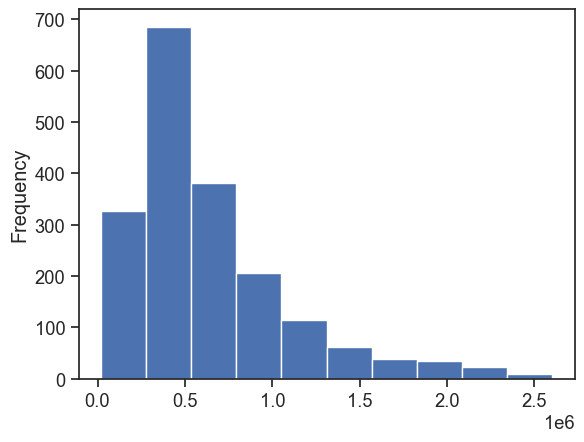

In [ ]:
milan_outliers.price.plot.hist()

In [ ]:
# drop missing values

milan_outliers["price"] = milan_outliers["price"].fillna(milan_outliers["price"].mean())
milan_house_price = milan_outliers.dropna()

In [ ]:
milan_house_price.isnull().sum()

rooms                   0
m2                      0
bathrooms               0
floor                   0
condominium_expenses    0
availability            0
price                   0
year_of_build           0
condition               0
air_conditioning        0
energy_efficiency       0
neighborhood            0
car_parking             0
elevator                0
energy_class            0
dtype: int64

In [ ]:
milan_house_price.shape

(1180, 15)

## Data Preprocessing

In [ ]:
bolean_features = ['air_conditioning', 'availability', 'car_parking', 'elevator']
milan_house_price[bolean_features] = milan_house_price[bolean_features].astype('int64')

milan_house_price.head()

,rooms,m2,bathrooms,floor,condominium_expenses,availability,price,year_of_build,condition,air_conditioning,energy_efficiency,neighborhood,car_parking,elevator,energy_class
0,3.0,140.0,2.0,4.0,535.0,1,880000.0,1900.0,very good / refurbished,1,248.59,centrale,0,1,D
1,4.0,121.0,2.0,3.0,200.0,1,649000.0,1960.0,very good / refurbished,1,3.51,centrale,0,1,E
2,2.0,55.0,1.0,4.0,133.0,1,300000.0,2006.0,good / habitable,1,183.89,viale ungheria - mecenate,1,1,E
3,2.0,60.0,1.0,5.0,333.0,1,250000.0,1960.0,very good / refurbished,1,138.8,città studi,0,1,F
5,4.0,136.0,2.0,7.0,325.0,1,920000.0,1969.0,good / habitable,1,167.86,solari,1,1,D


In [ ]:
milan_house_price.dtypes

rooms                   float64
m2                      float64
bathrooms               float64
floor                   float64
condominium_expenses    float64
availability              int64
price                   float64
year_of_build           float64
condition                object
air_conditioning          int64
energy_efficiency        object
neighborhood             object
car_parking               int64
elevator                  int64
energy_class             object
dtype: object

In [ ]:
from sklearn.preprocessing import OneHotEncoder

def get_categorical_variables(df):
    """
    Identifies and returns the list of categorical variables from a DataFrame.

    Args:
        df (pandas.DataFrame): The DataFrame to analyze.

    Returns:
        list: A list of column names representing the categorical variables.
        int: The total count of categorical features found in the DataFrame.
    """
    s = (df.dtypes == 'object')
    categorical_columns = list(s[s].index)
    count_categorical_features = len(categorical_columns)
    return categorical_columns, count_categorical_features

# Assuming milan_house_price is your pandas DataFrame containing the data

# Get the list of categorical variables and count of categorical features
categorical_vars, num_categorical_features = get_categorical_variables(milan_house_price)

print("Categorical variables:")
print(categorical_vars)
print('No. of. categorical features:', num_categorical_features)

Categorical variables:
['condition', 'energy_efficiency', 'neighborhood', 'energy_class']
No. of. categorical features: 4


In [ ]:
from sklearn.preprocessing import OneHotEncoder

# one hot encoder can handle Nan/None Values

def one_hot_encode_categorical(df, categorical_vars):
    """
    Performs one-hot encoding on the specified categorical columns of a DataFrame.

    Args:
        df (pandas.DataFrame): The DataFrame to encode.
        object_cols (list): List of column names representing the categorical variables.

    Returns:
        pandas.DataFrame: The DataFrame with one-hot encoded categorical columns.
    """
    one_encoder = OneHotEncoder(sparse=False)
    ohe_cols = pd.DataFrame(one_encoder.fit_transform(df[categorical_vars]))
    ohe_cols.index = df.index
    ohe_cols.columns = one_encoder.get_feature_names_out(input_features=categorical_vars)
    df_final = df.drop(categorical_vars, axis=1)
    df_final = pd.concat([df_final, ohe_cols], axis=1)
    return df_final

# Assuming milan_house_price is your pandas DataFrame containing the data
# Assuming object_cols contains the list of column names representing the categorical variables

# Perform one-hot encoding and obtain the final DataFrame
milan_house_final = one_hot_encode_categorical(milan_house_price, categorical_vars)

In [ ]:
milan_house_final

,rooms,m2,bathrooms,floor,condominium_expenses,availability,price,year_of_build,air_conditioning,car_parking,...,neighborhood_washington,neighborhood_zara,"energy_class_,",energy_class_A,energy_class_B,energy_class_C,energy_class_D,energy_class_E,energy_class_F,energy_class_G
0,3.0,140.0,2.0,4.0,535.0,1,880000.0,1900.0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,4.0,121.0,2.0,3.0,200.0,1,649000.0,1960.0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2.0,55.0,1.0,4.0,133.0,1,300000.0,2006.0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2.0,60.0,1.0,5.0,333.0,1,250000.0,1960.0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,4.0,136.0,2.0,7.0,325.0,1,920000.0,1969.0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2118,2.0,50.0,1.0,1.0,100.0,1,195000.0,1995.0,1,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2123,2.0,59.0,1.0,2.0,110.0,1,398000.0,1960.0,1,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2124,2.0,51.0,1.0,2.0,100.0,1,375000.0,1960.0,1,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2125,2.0,70.0,1.0,10.0,135.0,1,338000.0,2009.0,1,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## DATA MODELLING AND EVALUATION

#### Data scaling and Splitting into training and testing sets

In [ ]:
# Splitting data into features and labels ( X, y)
X = milan_house_final.drop('price', axis=1)
y = milan_house_final["price"]

# Feature normalisation
from sklearn.preprocessing import StandardScaler
S_scale = StandardScaler()
X_scaled = S_scale.fit_transform(X)

# Splitting data into training and testing sets

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((944, 692), (236, 692), (944,), (236,))

##### MODEL TRAINING AND EVALUATION

Regression models:
- Support Vector Machine (SVM)
- Gradient Boosting
- XGBOOST
- Random Forest Regressor
- ADABOOST


In [ ]:
# models
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor

# evaluation metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import  r2_score, mean_absolute_error, mean_squared_error

In [ ]:
models_results = pd.DataFrame(columns=["Model","MAE","MSE","RMSE","R2 Score","RMSE (Cross-Validation)"])

In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_rmse_cv(regression_model):
    """
    Calculate the root mean squared error (RMSE) using cross-validation for a regression model.

    Args:
        regression_model: The regression model to evaluate.
        X (array-like or DataFrame): Feature matrix.
        y (array-like or DataFrame): Target vector.

    Returns:
        float: The average RMSE across the cross-validation folds.
    """
    rmse = np.sqrt(-cross_val_score(regression_model, X, y, scoring="neg_mean_squared_error", cv=5)).mean()
    return rmse


def calculate_evaluation_metrics(y, predictions):
    mae = mean_absolute_error(y, predictions)
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mean_squared_error(y, predictions))
    r_squared = r2_score(y, predictions)
    return mae, mse, rmse, r_squared




In [ ]:
svr_model = SVR(C=100000)
svr_model.fit(X_train, y_train)
y_preds = svr_model.predict(X_test)

# Evaluate model
mae, mse, rmse, r_squared = calculate_evaluation_metrics(y_test, y_preds)
print("Regression metrics on test set")
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("-"*30)
rmse_cross_val = calculate_rmse_cv(svr_model)
print("RMSE Cross-Validation:", rmse_cross_val)


#adding results to dataframe
new_row = {
    "Model": "SVR",
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "R2 Score": r_squared,
    "RMSE (Cross-Validation)": rmse_cross_val
}
models_results = models_results.append(new_row, ignore_index=True)


Regression metrics on test set
MAE: 220907.8265490602
MSE: 119710653658.8136
RMSE: 345992.273987171
R2 Score: 0.325001598509012
------------------------------
RMSE Cross-Validation: 332699.396604234


In [ ]:
# Random Forest Regressor

rf_model = RandomForestRegressor()

rf_model.fit(X_train, y_train)

y_preds = rf_model.predict(X_test)

# Evaluate model
mae, mse, rmse, r_squared = calculate_evaluation_metrics(y_test, y_preds)
print("Regression metrics on test set")
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("-"*30)
rmse_cross_val = calculate_rmse_cv(rf_model)
print("RMSE Cross-Validation:", rmse_cross_val)


#adding results to dataframe
new_row = {
    "Model": "RandomForestRegressor",
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "R2 Score": r_squared,
    "RMSE (Cross-Validation)": rmse_cross_val
}
models_results= models_results.append(new_row, ignore_index=True)

Regression metrics on test set
MAE: 162320.51135295865
MSE: 69852139098.42203
RMSE: 264295.5525513474
R2 Score: 0.6061329481455919
------------------------------
RMSE Cross-Validation: 234706.37276956285


In [ ]:
# Evaluate model
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)
y_preds = gb_model.predict(X_test)

mae, mse, rmse, r_squared = calculate_evaluation_metrics(y_test, y_preds)
print("Regression metrics on test set")
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("-"*30)
rmse_cross_val = calculate_rmse_cv(gb_model)
print("RMSE Cross-Validation:", rmse_cross_val)


#adding results to dataframe
new_row = {
    "Model": "GradientBoostingRegressor",
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "R2 Score": r_squared,
    "RMSE (Cross-Validation)": rmse_cross_val
}
models_results = models_results.append(new_row, ignore_index=True)

Regression metrics on test set
MAE: 158928.4913777349
MSE: 63713215086.15147
RMSE: 252414.76796366624
R2 Score: 0.6407477778913837
------------------------------
RMSE Cross-Validation: 223877.50834147647


In [ ]:
# Evaluate model
xg_model =  XGBRegressor()
xg_model.fit(X_train, y_train)
y_preds = xg_model.predict(X_test)

mae, mse, rmse, r_squared = calculate_evaluation_metrics(y_test, y_preds)
print("Regression metrics on test set")
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("-"*30)
rmse_cross_val = calculate_rmse_cv(xg_model)
print("RMSE Cross-Validation:", rmse_cross_val)


#adding results to dataframe
new_row = {
    "Model": "XGBRegressor",
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "R2 Score": r_squared,
    "RMSE (Cross-Validation)": rmse_cross_val
}
models_results = models_results.append(new_row, ignore_index=True)

Regression metrics on test set
MAE: 160877.87883090848
MSE: 80322957585.17812
RMSE: 283413.051190622
R2 Score: 0.5470923738537959
------------------------------
RMSE Cross-Validation: 218085.56480343547


In [ ]:
ada_model = AdaBoostRegressor()
ada_model.fit(X_train, y_train)
y_preds = ada_model.predict(X_test)


mae, mse, rmse, r_squared = calculate_evaluation_metrics(y_test, y_preds)
print("Regression metrics on test set")
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("-"*30)
rmse_cross_val = calculate_rmse_cv(ada_model)
print("RMSE Cross-Validation:", rmse_cross_val)


#adding results to dataframe
new_row = {
    "Model": "AdaBoostRegressor",
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "R2 Score": r_squared,
    "RMSE (Cross-Validation)": rmse_cross_val
}
model_results = model_results.append(new_row, ignore_index=True)

Regression metrics on test set
MAE: 247812.78390803732
MSE: 103045635438.02603
RMSE: 321007.2202272498
R2 Score: 0.418968679266169
------------------------------
RMSE Cross-Validation: 263681.41868556576


### Model Comparison

In [ ]:
model_results.sort_values(by="RMSE (Cross-Validation)")

,Model,MAE,MSE,RMSE,R2 Score,RMSE (Cross-Validation)
6,XGBRegressor,160877.878831,8.032296e+10,283413.051191,0.547092,218085.564803
5,GradientBoostingRegressor,158928.491378,6.371322e+10,252414.767964,0.640748,223877.508341
1,RandomForestRegressor,160682.236075,7.038137e+10,265294.878967,0.603149,232779.522097
4,RandomForestRegressor,162320.511353,6.985214e+10,264295.552551,0.606133,234706.372770
2,RandomForestRegressor,159914.757071,6.833427e+10,261408.250291,0.614692,234804.668174
3,RandomForestRegressor,161900.927578,6.985504e+10,264301.046737,0.606117,235754.347813
7,AdaBoostRegressor,247812.783908,1.030456e+11,321007.220227,0.418969,263681.418686
0,SVR,220907.826549,1.197107e+11,345992.273987,0.325002,332699.396604
